# Install and Import Libraies

In [2]:
pip install -q efficientnet tensorflow-addons lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import DenseNet121, EfficientNetB4,MobileNetV3Large, VGG16, ResNet50
import efficientnet.tfkeras as efn

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries


2025-06-09 18:09:58.440340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749492598.910352      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749492599.032271      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Define Paths and Parameters

In [4]:
train_dir = "/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/train"
val_dir   = "/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/val"
test_dir  = "/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/test"


# Prepare Data Generators

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, rotation_range=10)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE),
                                              batch_size=BATCH_SIZE, class_mode='categorical')

val_gen = val_test_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE),
                                               batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

test_gen = val_test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE),
                                                batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)


Found 11923 images belonging to 34 classes.
Found 2544 images belonging to 34 classes.
Found 2585 images belonging to 34 classes.


# Show sample Images

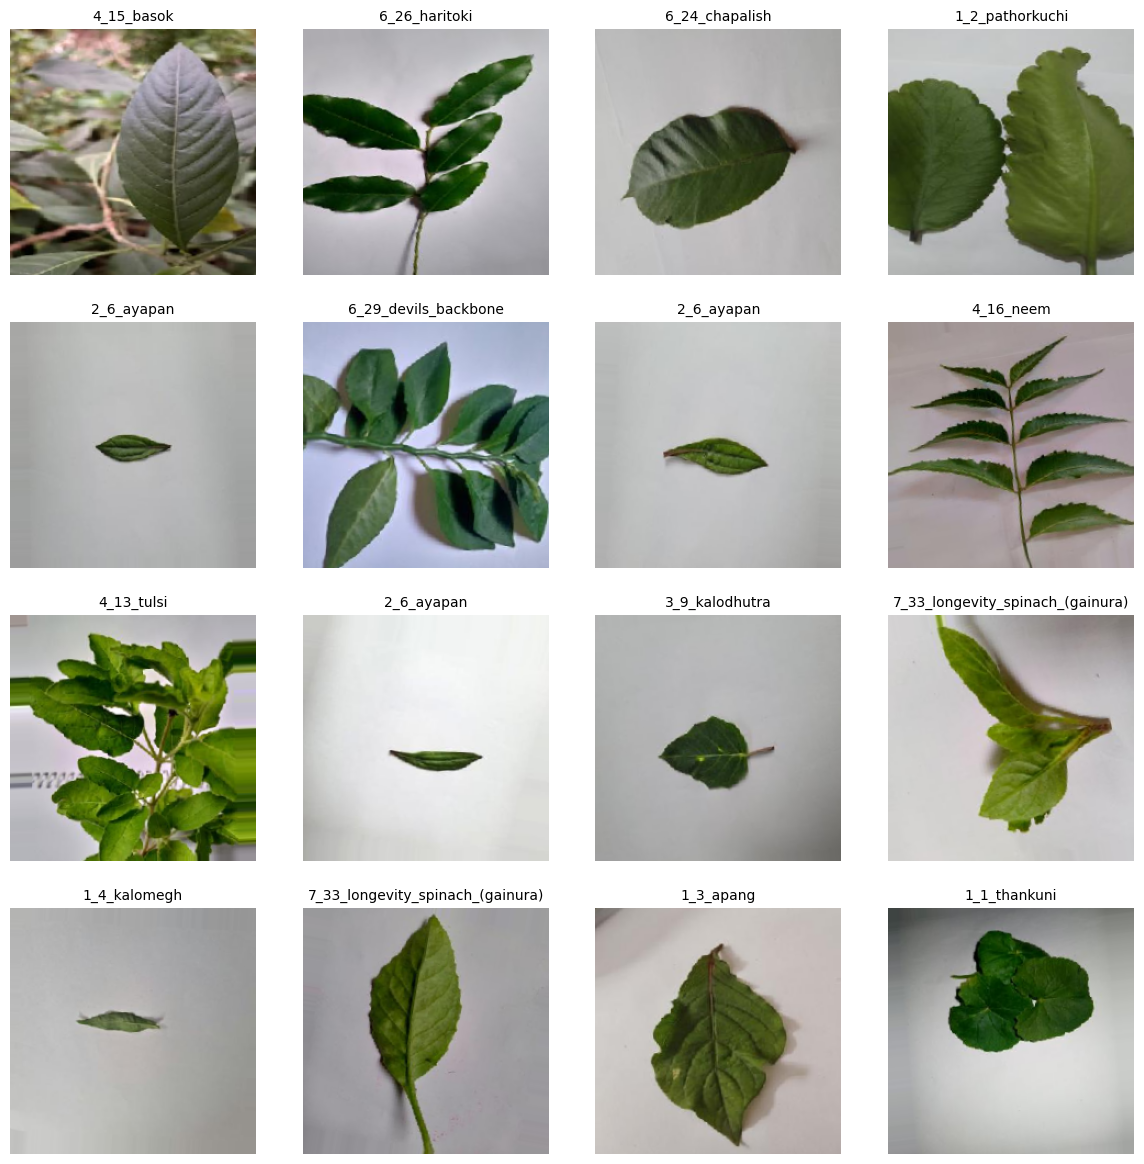

In [6]:
plt.figure(figsize=(12, 12))  # Adjusted for square images in a 4x4 grid
for i in range(16):
    img, label = next(train_gen)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[0])
    plt.title(class_names[np.argmax(label[0])], fontsize=10)
    plt.axis('off')
plt.tight_layout(pad=2.0)  # Adds padding between subplots
plt.show()


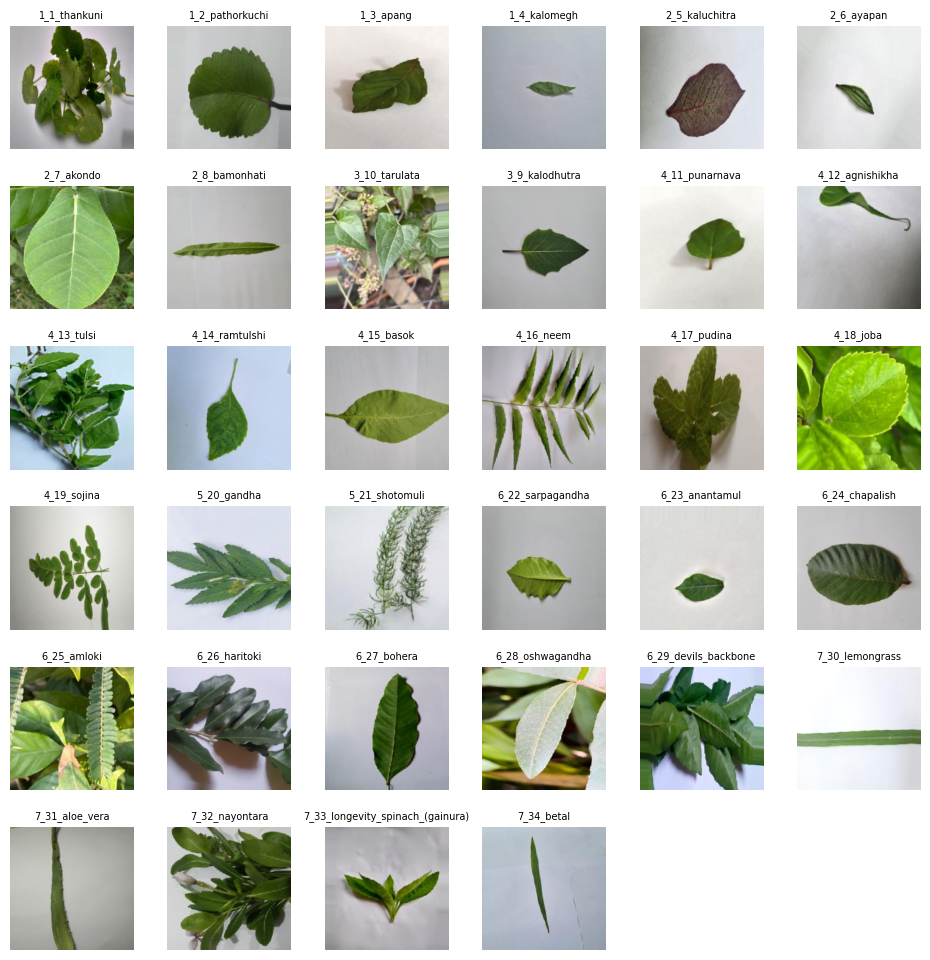

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Collect one image per class
collected_classes = set()
images_to_plot = []

while len(collected_classes) < 34:
    img, label = next(train_gen)
    class_index = np.argmax(label[0])
    if class_index not in collected_classes:
        collected_classes.add(class_index)
        images_to_plot.append((img[0], class_index))

# Sort by class index for consistent order
images_to_plot.sort(key=lambda x: x[1])

# Plot images tightly
fig = plt.figure(figsize=(12, 12))  # smaller figure = tighter layout
for i, (img, class_idx) in enumerate(images_to_plot):
    plt.subplot(6, 6, i + 1)  # 6x6 grid, 2 slots will remain empty
    plt.imshow(img)
    plt.title(class_names[class_idx], fontsize=7)
    plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)  # tighter spacing

# ✅ Save before showing
plt.savefig('34_class_images_grid.png', bbox_inches='tight', dpi=300)
plt.show()


# Build Model Function

In [8]:
def build_model(base_model, input_shape=(IMG_SIZE, IMG_SIZE, 3), n_classes=34):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model


# Buld and Compile Models


In [9]:
#base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
#base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
#base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

model = build_model(base_model, n_classes=num_classes)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


I0000 00:00:1749492729.533377      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749492729.534121      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train the Model

In [10]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
]

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1749492751.645378     130 service.cc:148] XLA service 0x7e2ef80458d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749492751.647067     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749492751.647088     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749492753.221659     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/373 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.0156 - loss: 3.9644       

I0000 00:00:1749492758.975377     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


373/373 ━━━━━━━━━━━━━━━━━━━━ 251s 625ms/step - accuracy: 0.0316 - loss: 3.7618 - val_accuracy: 0.0998 - val_loss: 3.4435 - learning_rate: 1.0000e-04
Epoch 2/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 149s 399ms/step - accuracy: 0.0488 - loss: 3.5673 - val_accuracy: 0.1112 - val_loss: 3.3732 - learning_rate: 1.0000e-04
Epoch 3/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 146s 392ms/step - accuracy: 0.0566 - loss: 3.4942 - val_accuracy: 0.1462 - val_loss: 3.3112 - learning_rate: 1.0000e-04
Epoch 4/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 148s 396ms/step - accuracy: 0.0703 - loss: 3.4180 - val_accuracy: 0.1427 - val_loss: 3.2576 - learning_rate: 1.0000e-04
Epoch 5/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 145s 389ms/step - accuracy: 0.0807 - loss: 3.3641 - val_accuracy: 0.1938 - val_loss: 3.2075 - learning_rate: 1.0000e-04
Epoch 6/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 143s 384ms/step - accuracy: 0.1000 - loss: 3.3113 - val_accuracy: 0.2075 - val_loss: 3.1645 - learning_rate: 1.0000e-04
Epoch 7/20
373/373 ━━━━━━━━━━━━━━━━━━━━ 147s 394ms/

# Unfreeze part of the base model for fine-tuning

In [11]:
# Unfreeze the base model
base_model.trainable = True

# Optionally: freeze early layers (to avoid overfitting)
for layer in base_model.layers[:100]:
    layer.trainable = False


In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training early if validation loss doesn’t improve for 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-6
)


In [14]:
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 169s 419ms/step - accuracy: 0.2285 - loss: 2.8785 - val_accuracy: 0.3589 - val_loss: 2.7827 - learning_rate: 1.0000e-05
Epoch 2/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 149s 399ms/step - accuracy: 0.2237 - loss: 2.8957 - val_accuracy: 0.3750 - val_loss: 2.7802 - learning_rate: 1.0000e-05
Epoch 3/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 149s 400ms/step - accuracy: 0.2270 - loss: 2.8950 - val_accuracy: 0.3833 - val_loss: 2.7783 - learning_rate: 1.0000e-05
Epoch 4/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 148s 396ms/step - accuracy: 0.2345 - loss: 2.8911 - val_accuracy: 0.3868 - val_loss: 2.7762 - learning_rate: 1.0000e-05
Epoch 5/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 149s 399ms/step - accuracy: 0.2381 - loss: 2.8904 - val_accuracy: 0.3864 - val_loss: 2.7746 - learning_rate: 1.0000e-05
Epoch 6/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 147s 395ms/step - accuracy: 0.2302 - loss: 2.8963 - val_accuracy: 0.3852 - val_loss: 2.7728 - learning_rate: 1.0000e-05
Epoch 7/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 

# Accuracy and Loss Curve

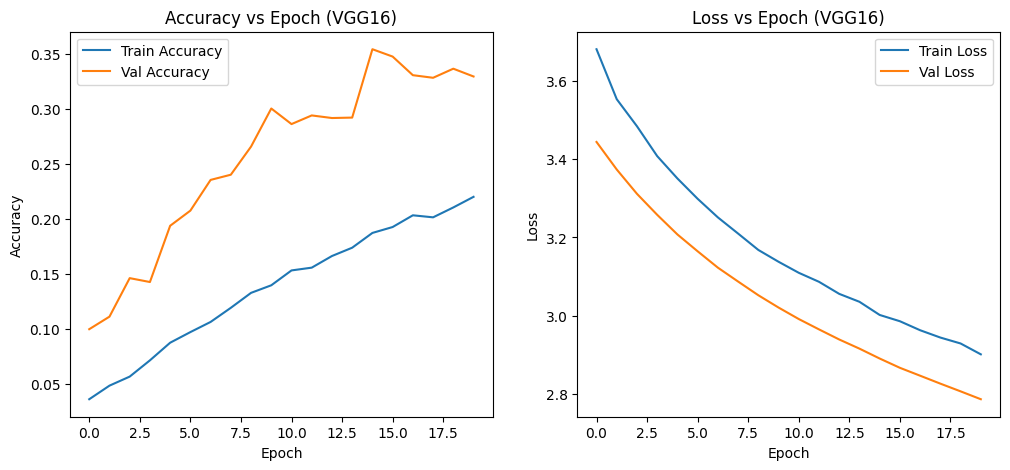

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch (VGG16)')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch (VGG16)')
plt.show()


# Evaluate on Test Data

In [16]:
test_gen.reset()
pred = model.predict(test_gen, verbose=1)
y_pred = np.argmax(pred, axis=1)
y_true = test_gen.classes


81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 471ms/step


# Confusion Matrix

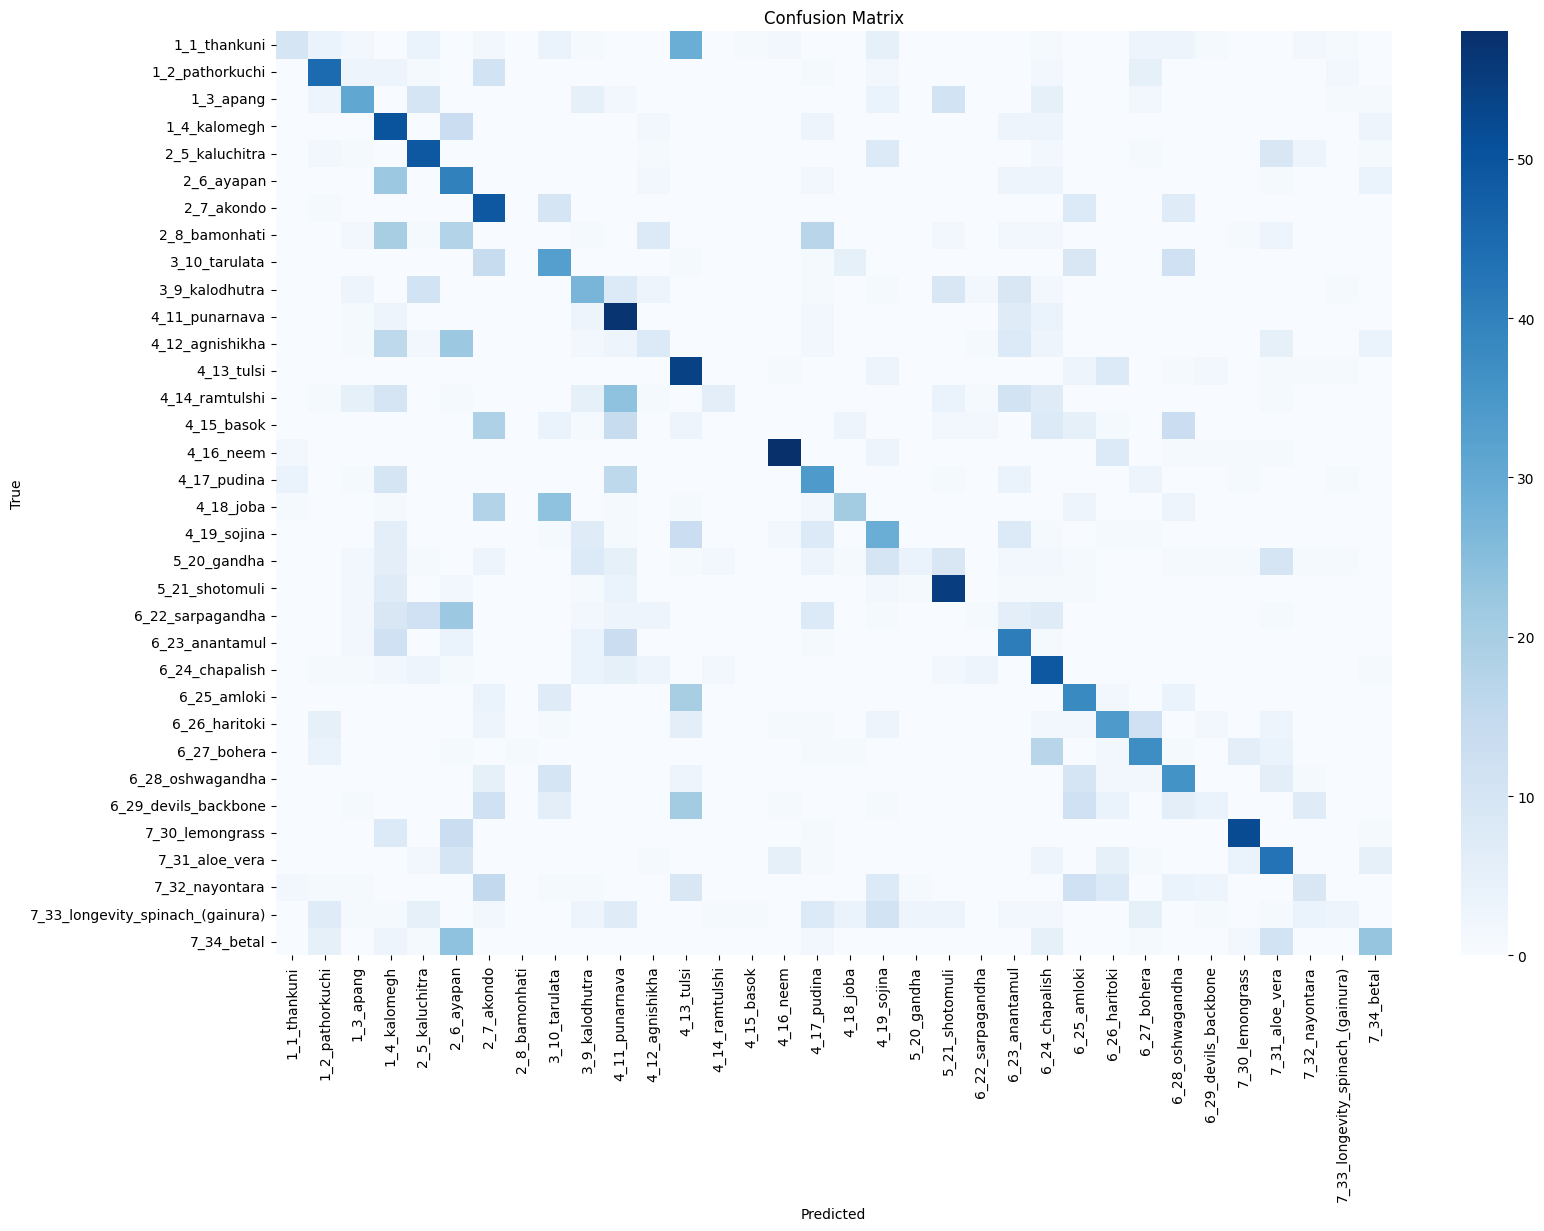

In [17]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Classification Report

In [18]:
print(classification_report(y_true, y_pred, target_names=class_names))


                                  precision    recall  f1-score   support

                    1_1_thankuni       0.53      0.13      0.21        75
                 1_2_pathorkuchi       0.57      0.60      0.58        75
                       1_3_apang       0.50      0.41      0.45        75
                    1_4_kalomegh       0.26      0.65      0.38        77
                  2_5_kaluchitra       0.48      0.64      0.55        77
                      2_6_ayapan       0.23      0.52      0.32        77
                      2_7_akondo       0.31      0.65      0.42        75
                   2_8_bamonhati       0.00      0.00      0.00        77
                   3_10_tarulata       0.33      0.44      0.38        75
                  3_9_kalodhutra       0.36      0.35      0.36        77
                  4_11_punarnava       0.35      0.74      0.47        77
                 4_12_agnishikha       0.25      0.10      0.15        77
                      4_13_tulsi     

# ROC Curve (Macro-Aceraged)

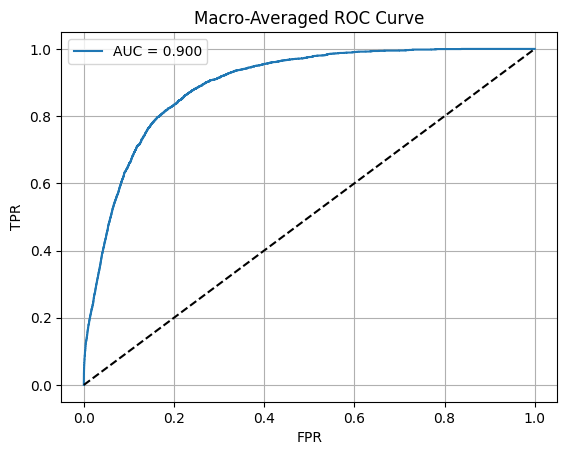

In [19]:
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), pred.ravel())
roc_auc = roc_auc_score(y_true_bin, pred, average="macro")

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Macro-Averaged ROC Curve')
plt.legend()
plt.grid()
plt.show()


# Grad-CAM Visualization

In [20]:
def grad_cam(model, image, class_index, layer_name='conv5_block16_concat'):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

image = test_gen[0][0][0]
label_idx = np.argmax(test_gen[0][1][0])
cam = grad_cam(model, image, label_idx)

plt.imshow(image)
plt.imshow(cam, cmap='jet', alpha=0.4)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


ValueError: No such layer: conv5_block16_concat. Existing layers are: ['input_layer_4', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn', 'conv3_block1_3_bn', 'conv3_block1_add', 'conv3_block1_out', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_conv', 'conv3_block2_2_bn', 'conv3_block2_2_relu', 'conv3_block2_3_conv', 'conv3_block2_3_bn', 'conv3_block2_add', 'conv3_block2_out', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_conv', 'conv3_block3_2_bn', 'conv3_block3_2_relu', 'conv3_block3_3_conv', 'conv3_block3_3_bn', 'conv3_block3_add', 'conv3_block3_out', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_conv', 'conv3_block4_2_bn', 'conv3_block4_2_relu', 'conv3_block4_3_conv', 'conv3_block4_3_bn', 'conv3_block4_add', 'conv3_block4_out', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_conv', 'conv4_block1_2_bn', 'conv4_block1_2_relu', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block1_0_bn', 'conv4_block1_3_bn', 'conv4_block1_add', 'conv4_block1_out', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_conv', 'conv4_block2_2_bn', 'conv4_block2_2_relu', 'conv4_block2_3_conv', 'conv4_block2_3_bn', 'conv4_block2_add', 'conv4_block2_out', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_conv', 'conv4_block3_2_bn', 'conv4_block3_2_relu', 'conv4_block3_3_conv', 'conv4_block3_3_bn', 'conv4_block3_add', 'conv4_block3_out', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_conv', 'conv4_block4_2_bn', 'conv4_block4_2_relu', 'conv4_block4_3_conv', 'conv4_block4_3_bn', 'conv4_block4_add', 'conv4_block4_out', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_conv', 'conv4_block5_2_bn', 'conv4_block5_2_relu', 'conv4_block5_3_conv', 'conv4_block5_3_bn', 'conv4_block5_add', 'conv4_block5_out', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_conv', 'conv4_block6_2_bn', 'conv4_block6_2_relu', 'conv4_block6_3_conv', 'conv4_block6_3_bn', 'conv4_block6_add', 'conv4_block6_out', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_conv', 'conv5_block1_2_bn', 'conv5_block1_2_relu', 'conv5_block1_0_conv', 'conv5_block1_3_conv', 'conv5_block1_0_bn', 'conv5_block1_3_bn', 'conv5_block1_add', 'conv5_block1_out', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_conv', 'conv5_block2_2_bn', 'conv5_block2_2_relu', 'conv5_block2_3_conv', 'conv5_block2_3_bn', 'conv5_block2_add', 'conv5_block2_out', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_3_bn', 'conv5_block3_add', 'conv5_block3_out', 'global_average_pooling2d', 'dropout', 'dense'].

# LIME Image Explanation

In [21]:
explainer = lime_image.LimeImageExplainer()
img = (image * 255).astype(np.uint8)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(label_idx, positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━

KeyError: 'Label not in explanation'

# t-SNE Visualization of Features

In [ ]:
features_model = Model(inputs=model.input, outputs=model.layers[-3].output)
features = features_model.predict(test_gen)
tsne = TSNE(n_components=2, random_state=42).fit_transform(features)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=y_true, cmap='tab20', s=10)
plt.colorbar()
plt.title("t-SNE of Feature Space")
plt.show()


# Show Model Architecture

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Save the model architecture diagram
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display it inline (Kaggle-compatible)
display(Image(filename='model_architecture.png'))


# Calculate total model size in MB

In [ ]:
import numpy as np

# Count total parameters
trainable_count = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_count = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
total_params = trainable_count + non_trainable_count

# Convert to MB (assuming float32 = 4 bytes)
model_size_MB = total_params * 4 / (1024 ** 2)

print(f"🧠 Total Model Parameters: {total_params:,}")
print(f"💾 Estimated Model Size: {model_size_MB:.2f} MB")


# Save Model

In [22]:
model.save("medicinal_leaf_classifier_pretainedModel_VGG16.h5")

In [23]:
from tensorflow.keras.models import load_model

# Load your pre-trained model
model = load_model("/kaggle/working/medicinal_leaf_classifier_pretainedModel_VGG16.h5")


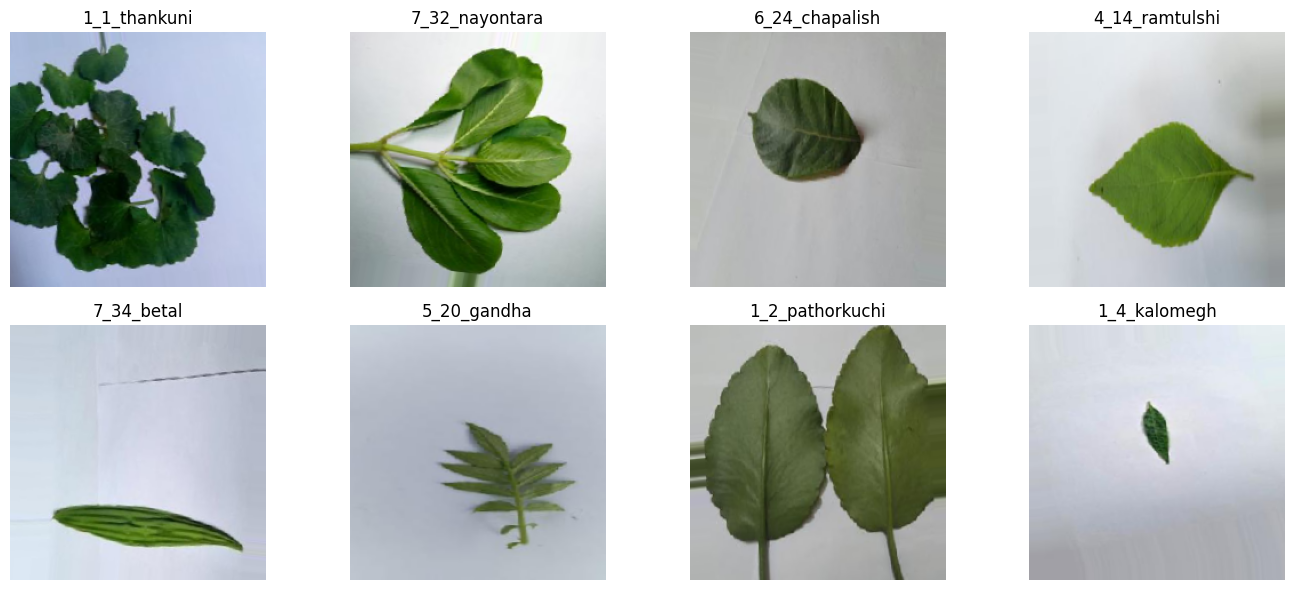

In [24]:
plt.figure(figsize=(14, 6))
for i in range(8):
    img, label = next(train_gen)
    plt.subplot(2, 4, i+1)
    plt.imshow(img[0])
    plt.title(class_names[np.argmax(label[0])])
    plt.axis('off')
plt.tight_layout()
plt.show()
